In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from tree import Tree

np.seterr(all="ignore")
if not hasattr(np, 'alltrue'):
    np.alltrue = np.all

In [2]:
NUM_ISLANDS = 5
ISLAND_SIZE = 100
GENERATIONS = 1000
MAX_DEPTH = 5
MUTATION_RATE = 0.3
TOURNAMENT_SIZE = 3
MIGRATION_INTERVAL = 250
MIGRATION_SIZE = 2
PRINT_INTERVAL = 200
TREE_ATTEMPTS = 10
TEST_TRAIN = 0.8

In [3]:
def plot_fitness_trend(fitness_history):
    """
    Plot the trend of best fitness over generations.

    Parameters:
        fitness_history (list): A list of best fitness values recorded over generations.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, linestyle='-', color='blue', linewidth=2, label='Best Fitness')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
def plot_predictions(y_test, y_pred):
    """
    Plots a comparison between actual and predicted values with sorting.

    Parameters:
        y_test: The actual values from the test dataset.
        y_pred: The predicted values generated by the model.
    """

    sorted_indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sorted_indices]
    y_pred_sorted = np.array(y_pred)[sorted_indices]

    plt.figure(figsize=(10, 5))

    plt.plot(y_test_sorted, label="Truth", color="red", linewidth=2)
    plt.plot(y_pred_sorted, label="Prediction", color="blue", linewidth=1)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Actual vs Predicted Values")
    plt.legend()
    plt.grid()
    plt.show()


In [5]:
class SymbolicRegressionGP:
    def __init__(self,
                 x_train,
                 y_train,
                 num_islands=NUM_ISLANDS,
                 island_size=ISLAND_SIZE,
                 generations=GENERATIONS, 
                 max_depth=MAX_DEPTH,
                 mutation_rate=MUTATION_RATE,
                 tournament_size=TOURNAMENT_SIZE,
                 migration_interval=MIGRATION_INTERVAL,
                 migration_size=MIGRATION_SIZE,
                 print_interval=PRINT_INTERVAL,
                 tree_attempts=TREE_ATTEMPTS):
        """
        Initialize the Symbolic Regression Genetic Programming (GP) model.

        Parameters:
            x_train, y_train: Training data arrays.
            num_islands: Number of islands (subpopulations).
            island_size: Number of trees per island.
            generations: Number of generations to run.
            max_depth: Maximum depth allowed for generated trees.
            mutation_rate: Probability that an offspring is mutated.
            tournament_size: Number of individuals in tournament selection.
            migration_interval: How often (in generations) migration occurs.
            migration_size: How many individuals migrate from each island.
            print_interval: Interval for printing progress.
            tree_attempts: Number of attempts to generate a valid tree.
        """
        self.x_train = x_train
        self.y_train = y_train
        self.num_islands = num_islands
        self.island_size = island_size
        self.generations = generations
        self.max_depth = max_depth
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.migration_interval = migration_interval
        self.migration_size = migration_size
        self.print_interval = print_interval
        self.tree_attempts = tree_attempts

        # List of islands; each island is a list of Tree objects.
        self.populations = []

    def initialize_population(self):
        """Initialize each island with random trees."""
        self.populations = []
        for i in range(self.num_islands):
            island = []        
            while len(island) < self.island_size:
                tree = Tree(max_depth=self.max_depth, x_train=self.x_train, y_train=self.y_train, tree_attempts=self.tree_attempts)
                tree.populate()
                if np.isfinite(tree.fitness):
                    island.append(tree)
            self.populations.append(island)

    def tournament_selection(self, population):
        """
        Select one individual from a population using rank-based tournament selection.

        Parameters:
            population: List of Tree objects representing the population.

        Returns:
            A single individual (tree) selected from the tournament.
        """

        tournament_size = min(self.tournament_size, len(population))
        participants = random.sample(population, tournament_size)
        
        # Sort participants so that the best individual (lowest fitness) is first.
        participants.sort(key=lambda tree: tree.fitness)
        
        # Compute rank-based weights.
        weights = [tournament_size - i for i in range(tournament_size)]
        
        # Use the weights to choose one candidate.
        chosen = random.choices(participants, weights=weights, k=1)[0]
        return chosen

    def migrate(self):
        """
        Migrate the best individuals from each island to the next island (in a ring).
        Here, for each island we select the best `migration_size` individuals and
        replace the worst individuals of the neighboring island if they are better.
        """
        for i in range(self.num_islands):
            source = self.populations[i]
            target_index = (i + 1) % self.num_islands  # next island (ring topology)
            target = self.populations[target_index]
            
            # Get the top individuals from the source island.
            migrants = sorted(source, key=lambda tree: tree.fitness)[:self.migration_size]
            # Sort the target island from worst to best.
            target_sorted = sorted(target, key=lambda tree: tree.fitness, reverse=True)
            
            for j in range(self.migration_size):
                # Replace if the migrant is better than the corresponding worst in target.
                if migrants[j].fitness < target_sorted[j].fitness:
                    index_to_replace = target.index(target_sorted[j])
                    target[index_to_replace] = migrants[j].clone_tree()
            self.populations[target_index] = target

    def run(self):
        """
        Run the genetic programming algorithm.

        Returns:
            best_tree: The best tree found during the run.
            best_fitness_history: List of the best fitness values over generations.
        """
        self.initialize_population()
        best_tree = None
        best_fitness = np.inf
        best_fitness_history = []

        for gen in tqdm(range(self.generations), desc="Generations"):
            # Evolve each island separately.
            for island_index in range(self.num_islands):
                current_pop = self.populations[island_index]
                new_pop = []
                elite = min(current_pop, key=lambda tree: tree.fitness)
                new_pop.append(elite.clone_tree())
                while len(new_pop) < self.island_size:
                    if random.random() < self.mutation_rate:
                        parent = self.tournament_selection(current_pop)
                        child = parent.clone_tree()
                        child.mutate()
                        new_pop.append(child)
                    else:
                        parent1 = self.tournament_selection(current_pop)
                        parent2 = self.tournament_selection(current_pop)
                        child1, child2 = parent1.recombine(parent2)
                        new_pop.append(child1)
                        new_pop.append(child2)
                self.populations[island_index] = np.concatenate((self.populations[island_index], new_pop))
                self.populations[island_index] = sorted(self.populations[island_index], key=lambda tree: tree.fitness)
                self.populations[island_index] = self.populations[island_index][:self.island_size]
                
            # Migration step.
            if (gen + 1) % self.migration_interval == 0:
                self.migrate()

            if (gen + 1) % self.print_interval == 0:
                print(f"Generation {gen + 1}:")
            # Update best overall solution.
            idx = 0
            for island_index in range(self.num_islands):
                current_pop = self.populations[island_index]
                best_island_tree = min(current_pop, key=lambda tree: tree.fitness)
                if (gen + 1) % self.print_interval == 0:
                    print(f"    Island {idx + 1}; Best fitness: {best_island_tree.fitness:.6f}")
                    idx += 1
                if best_island_tree.fitness < best_fitness:
                    best_fitness = best_island_tree.fitness
                    best_tree = best_island_tree.clone_tree()
                    
            best_fitness_history.append(best_fitness)
            if (gen + 1) % self.print_interval == 0:
                print(f"    Best global fitness: {best_fitness:.6f}")
                print(f"    Best global formula: {best_tree}\n")
        return best_tree, best_fitness_history

In [6]:
def run_sym_reg_gp(problem_num):    
    """
    Run symbolic regression using Genetic Programming (GP) on a specified problem.
    This function loads a dataset corresponding to the given problem number, shuffles the data,
    splits it into training and testing sets, and then runs a symbolic regression GP algorithm.
    The best resulting formula is evaluated on both the training and testing sets, and the results
    are printed and plotted.
    
    Parameters:
        problem_num (int): The problem number corresponding to the dataset to be loaded.
    """
    problem = np.load(f'./data/problem_{problem_num}.npz')
    x_1 = problem['x']
    y_1 = problem['y']
    problem_len = len(y_1)

    # Shuffle the data
    permutation = np.random.permutation(problem_len)
    x_1 = x_1[:, permutation]
    y_1 = y_1[permutation]

    # Determine train-test split sizes
    train_size = int(TEST_TRAIN * problem_len)

    # Split data into training and testing sets
    x_train = x_1[:, :train_size]
    y_train = y_1[:train_size]
    x_test = x_1[:, train_size:]
    y_test = y_1[train_size:]

    # Instantiate and run the symbolic regression GP
    gp = SymbolicRegressionGP(x_train,
                              y_train,
                              num_islands=NUM_ISLANDS,
                              island_size=ISLAND_SIZE,
                              generations=GENERATIONS,
                              max_depth=MAX_DEPTH,
                              mutation_rate=MUTATION_RATE,
                              tournament_size=TOURNAMENT_SIZE,
                              migration_interval=MIGRATION_INTERVAL,
                              migration_size=MIGRATION_SIZE,
                              print_interval=PRINT_INTERVAL
                              )
    
    print(f"\n\nProblem {problem_num}\n")
    best_tree, best_fitness_history = gp.run()

    # Evaluate the best tree on the test set
    new_tree = best_tree.clone_tree()
    new_tree.x_train = x_test
    new_tree.y_train = y_test
    y_pred = new_tree.compute_fitness(True)

    # Print results
    print("Best global formula: ", best_tree)
    print("Best training fitness: ", best_tree.fitness)
    print("Best testing fitness: ", new_tree.fitness)

    # Plot the best tree and fitness trend
    best_tree.plot()
    plot_fitness_trend(best_fitness_history)
    plot_predictions(y_test, y_pred)

### Problem 0



Problem 0



Generations:  20%|██        | 201/1000 [00:20<01:26,  9.29it/s]

Generation 200:
    Island 1; Best fitness: 0.010767
    Island 2; Best fitness: 0.010767
    Island 3; Best fitness: 0.010767
    Island 4; Best fitness: 0.001716
    Island 5; Best fitness: 0.010767
    Best global fitness: 0.001716
    Best global formula: np.subtract(x[0], np.tanh(np.sin(np.sin(np.multiply(x[1], -0.25936513783336634)))))



Generations:  40%|████      | 401/1000 [00:45<01:14,  7.99it/s]

Generation 400:
    Island 1; Best fitness: 0.000017
    Island 2; Best fitness: 0.000091
    Island 3; Best fitness: 0.000037
    Island 4; Best fitness: 0.000024
    Island 5; Best fitness: 0.000317
    Best global fitness: 0.000017
    Best global formula: np.subtract(x[0], np.tanh(np.tanh(np.sin(np.multiply(x[1], -0.1817006964170753)))))



Generations:  60%|██████    | 601/1000 [01:13<01:00,  6.60it/s]

Generation 600:
    Island 1; Best fitness: 0.000017
    Island 2; Best fitness: 0.000017
    Island 3; Best fitness: 0.000017
    Island 4; Best fitness: 0.000017
    Island 5; Best fitness: 0.000017
    Best global fitness: 0.000017
    Best global formula: np.subtract(x[0], np.tanh(np.tanh(np.tanh(np.multiply(x[1], -0.1817006964170753)))))



Generations:  80%|████████  | 801/1000 [01:43<00:28,  7.02it/s]

Generation 800:
    Island 1; Best fitness: 0.000017
    Island 2; Best fitness: 0.000017
    Island 3; Best fitness: 0.000017
    Island 4; Best fitness: 0.000017
    Island 5; Best fitness: 0.000017
    Best global fitness: 0.000017
    Best global formula: np.subtract(x[0], np.tanh(np.tanh(np.tanh(np.multiply(x[1], -0.1817006964170753)))))



Generations: 100%|██████████| 1000/1000 [02:12<00:00,  7.52it/s]


Generation 1000:
    Island 1; Best fitness: 0.000017
    Island 2; Best fitness: 0.000017
    Island 3; Best fitness: 0.000017
    Island 4; Best fitness: 0.000017
    Island 5; Best fitness: 0.000017
    Best global fitness: 0.000017
    Best global formula: np.subtract(np.reciprocal(np.reciprocal(x[0])), np.tanh(np.tanh(np.tanh(np.multiply(x[1], -0.1817006964170753)))))

Best global formula:  np.subtract(np.reciprocal(np.reciprocal(x[0])), np.tanh(np.tanh(np.tanh(np.multiply(x[1], -0.1817006964170753)))))
Best training fitness:  1.7145608753084673e-05
Best testing fitness:  1.738857235297222e-05


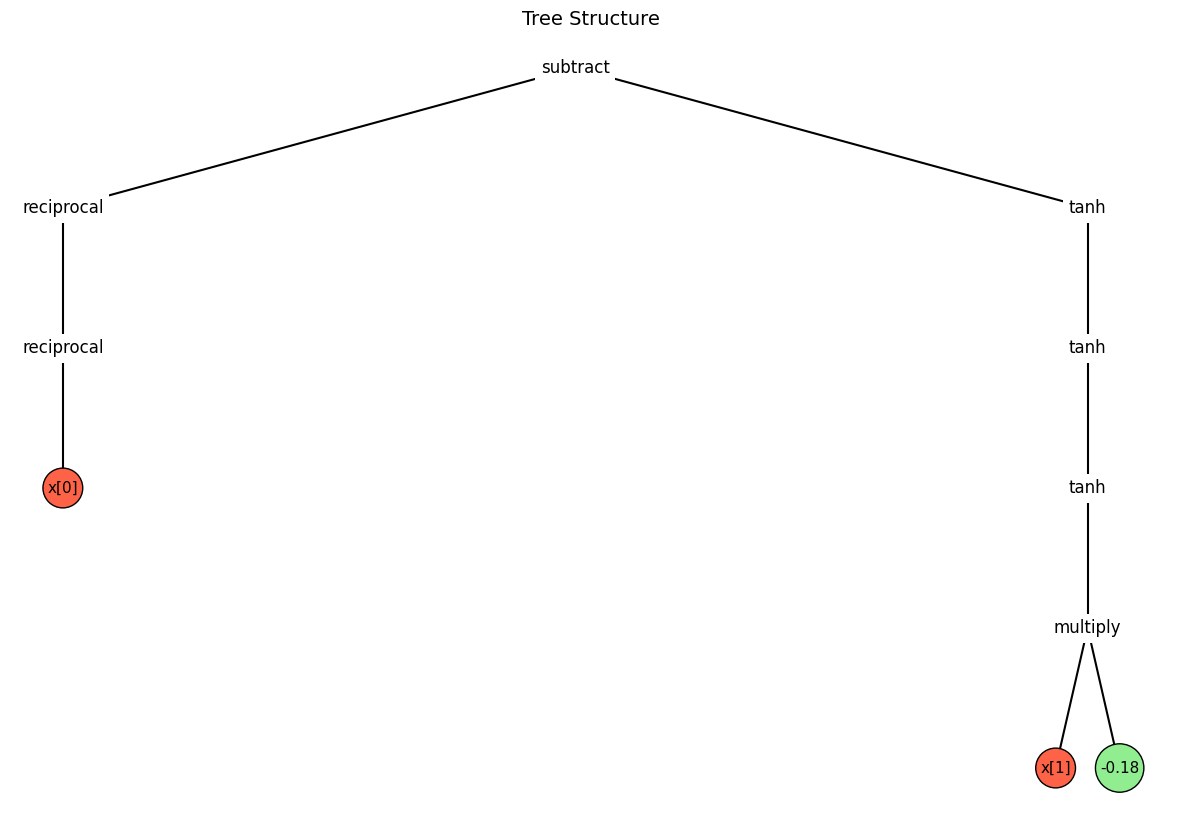

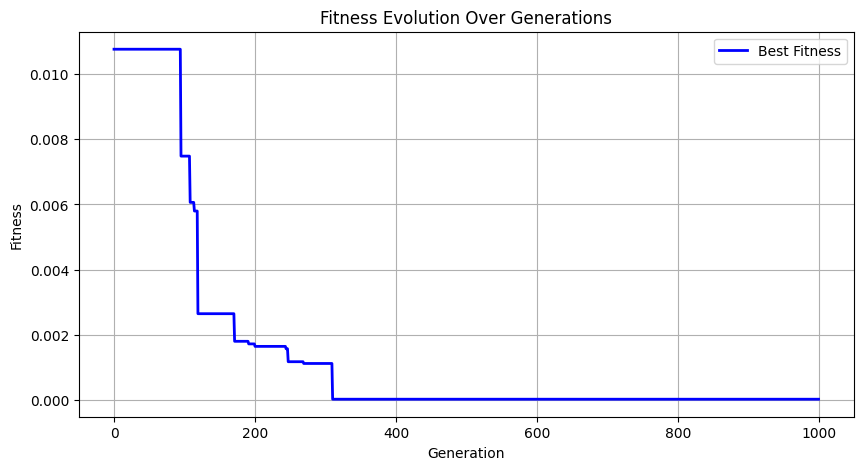

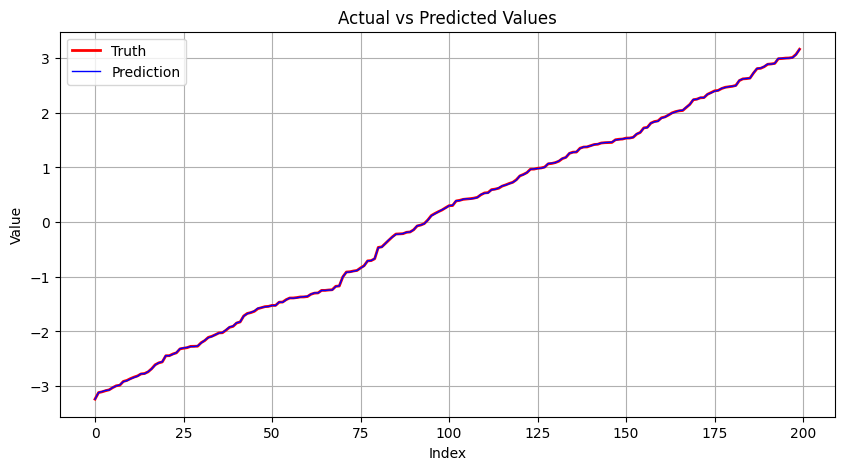

In [7]:
run_sym_reg_gp(0)

### Problem 1



Problem 1



Generations:  20%|██        | 201/1000 [00:19<01:15, 10.63it/s]

Generation 200:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations:  40%|████      | 402/1000 [00:39<00:59, 10.07it/s]

Generation 400:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations:  60%|██████    | 602/1000 [00:59<00:38, 10.45it/s]

Generation 600:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations:  80%|████████  | 801/1000 [01:20<00:19, 10.08it/s]

Generation 800:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations: 100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]

Generation 1000:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])

Best global formula:  np.sin(x[0])
Best training fitness:  7.578534331163773e-34
Best testing fitness:  5.3155666465087705e-34


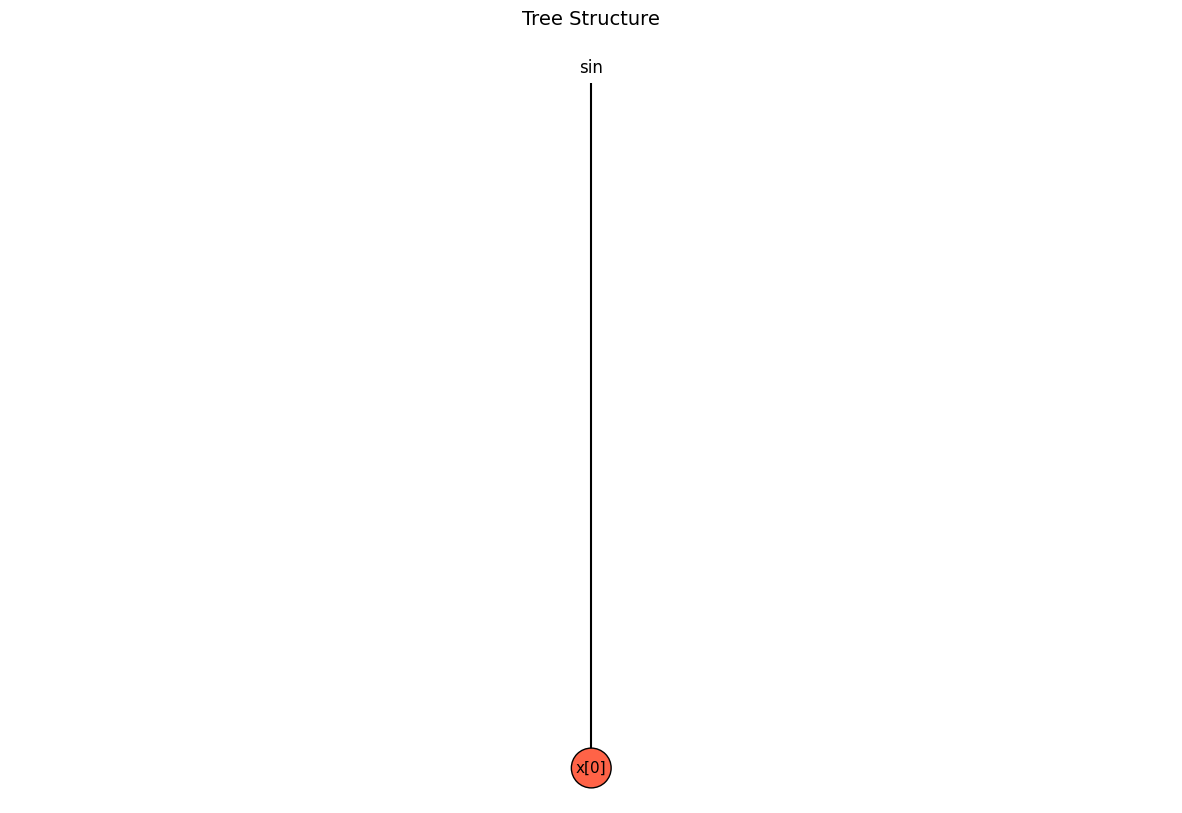

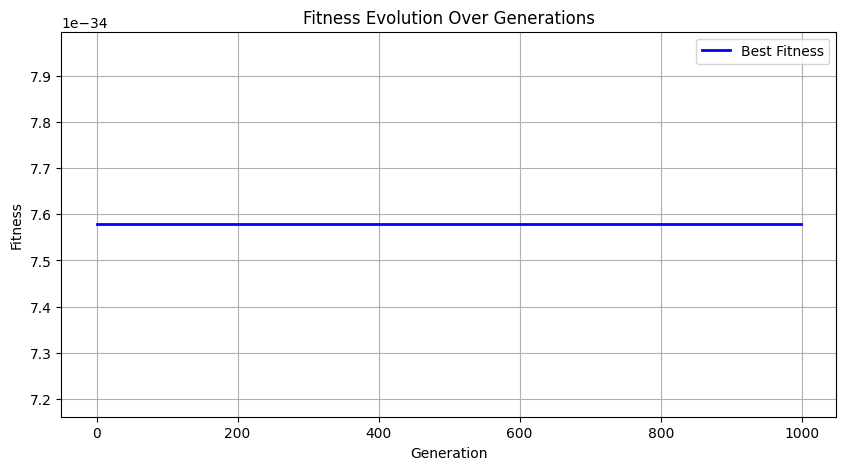

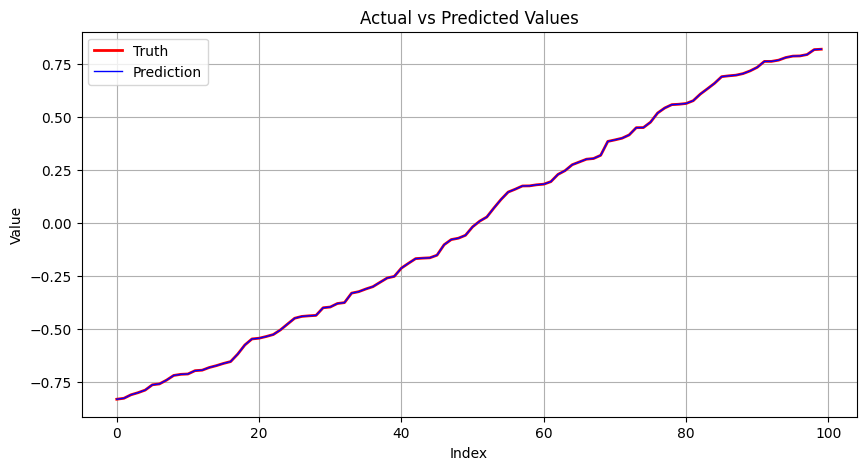

In [8]:
run_sym_reg_gp(1)

### Problem 2



Problem 2



Generations:  20%|██        | 201/1000 [00:37<02:24,  5.54it/s]

Generation 200:
    Island 1; Best fitness: 25705969337345.390625
    Island 2; Best fitness: 17869792176212.597656
    Island 3; Best fitness: 24332132709348.742188
    Island 4; Best fitness: 18912987125802.726562
    Island 5; Best fitness: 26592680932265.292969
    Best global fitness: 17869792176212.597656
    Best global formula: np.multiply(np.sinh(np.square(2.8472002685250386)), np.multiply(np.arctan(x[0]), np.sinh(np.square(2.8472002685250386))))



Generations:  40%|████      | 400/1000 [01:16<01:52,  5.32it/s]

Generation 400:
    Island 1; Best fitness: 15067878183296.539062
    Island 2; Best fitness: 14109069229739.259766
    Island 3; Best fitness: 17705331884165.890625
    Island 4; Best fitness: 17706927386095.621094
    Island 5; Best fitness: 17109732056134.193359
    Best global fitness: 14109069229739.259766
    Best global formula: np.multiply(np.cosh(np.square(np.cosh(-1.70765096352428))), np.multiply(np.arctan(np.add(np.add(x[1], x[0]), x[0])), np.cosh(np.square(np.cosh(-1.70765096352428)))))



Generations:  60%|██████    | 601/1000 [01:48<00:57,  6.88it/s]

Generation 600:
    Island 1; Best fitness: 7928079903071.255859
    Island 2; Best fitness: 8014794449262.036133
    Island 3; Best fitness: 7964819357968.190430
    Island 4; Best fitness: 7921456827681.947266
    Island 5; Best fitness: 8005638455884.929688
    Best global fitness: 7921456827681.947266
    Best global formula: np.multiply(np.multiply(np.arctan(np.add(np.add(x[1], x[2]), np.divide(x[0], 0.4916777920198925))), 1918.255311478139), np.cosh(np.square(np.absolute(-2.8726848891920325))))



Generations:  80%|████████  | 801/1000 [02:15<00:23,  8.57it/s]

Generation 800:
    Island 1; Best fitness: 7914372196917.239258
    Island 2; Best fitness: 7914372196917.239258
    Island 3; Best fitness: 7914372196917.239258
    Island 4; Best fitness: 7914372196917.239258
    Island 5; Best fitness: 7914372196917.239258
    Best global fitness: 7914372196917.239258
    Best global formula: np.multiply(np.cosh(np.negative(np.square(-2.891705823115304))), np.multiply(np.arctan(np.add(np.add(x[1], x[2]), np.add(x[0], x[0]))), np.cosh(np.square(np.cosh(-1.70765096352428)))))



Generations: 100%|██████████| 1000/1000 [02:37<00:00,  6.37it/s]

Generation 1000:
    Island 1; Best fitness: 7914372196917.239258
    Island 2; Best fitness: 7914372196917.239258
    Island 3; Best fitness: 7914372196917.239258
    Island 4; Best fitness: 7914372196917.239258
    Island 5; Best fitness: 7914372196917.239258
    Best global fitness: 7914372196917.239258
    Best global formula: np.multiply(np.cosh(np.negative(np.square(-2.891705823115304))), np.multiply(np.arctan(np.add(np.add(x[1], x[2]), np.add(x[0], x[0]))), np.cosh(np.square(np.cosh(-1.70765096352428)))))

Best global formula:  np.multiply(np.cosh(np.negative(np.square(-2.891705823115304))), np.multiply(np.arctan(np.add(np.add(x[1], x[2]), np.add(x[0], x[0]))), np.cosh(np.square(np.cosh(-1.70765096352428)))))
Best training fitness:  7914372196917.239
Best testing fitness:  8853964142452.135


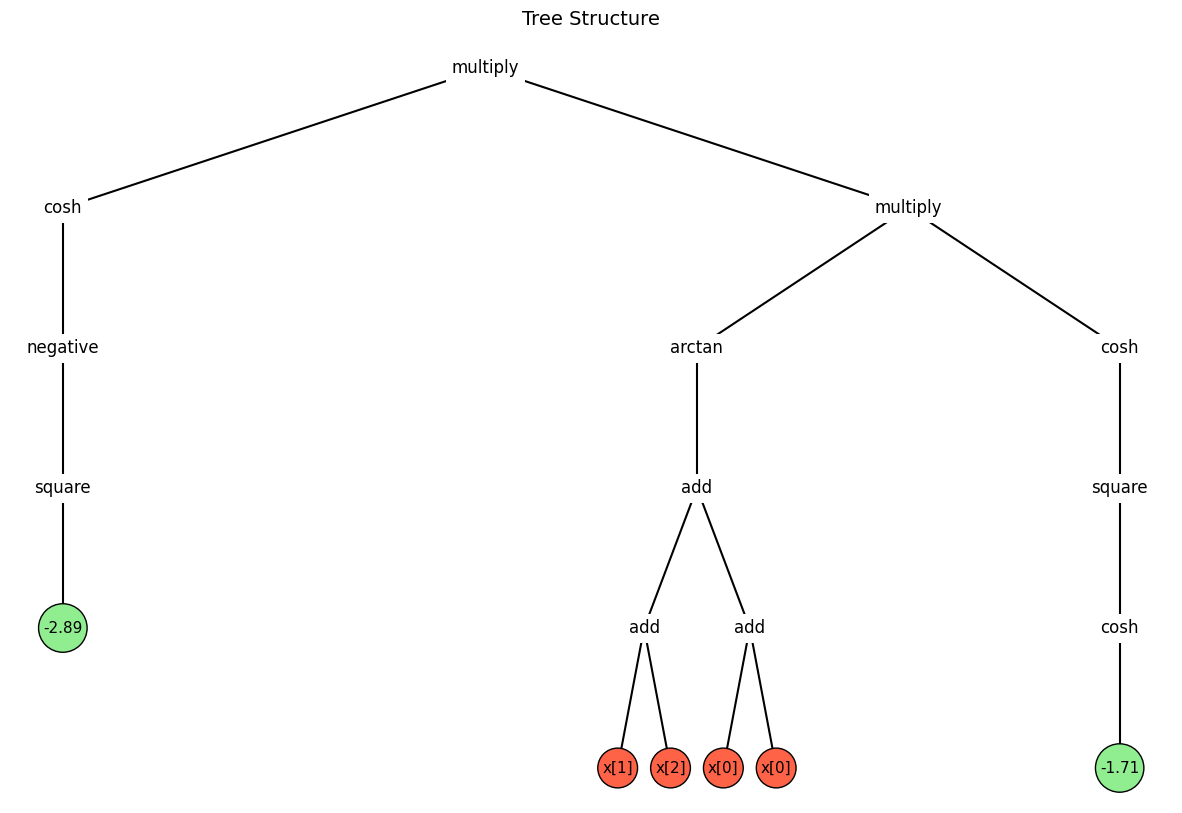

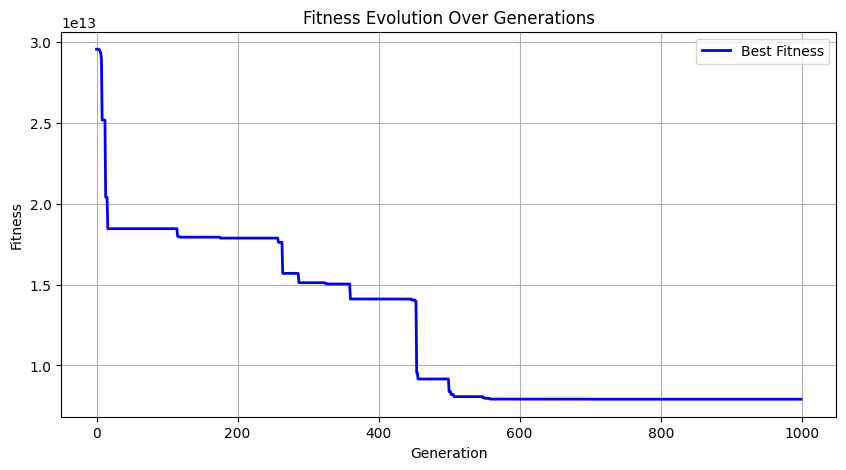

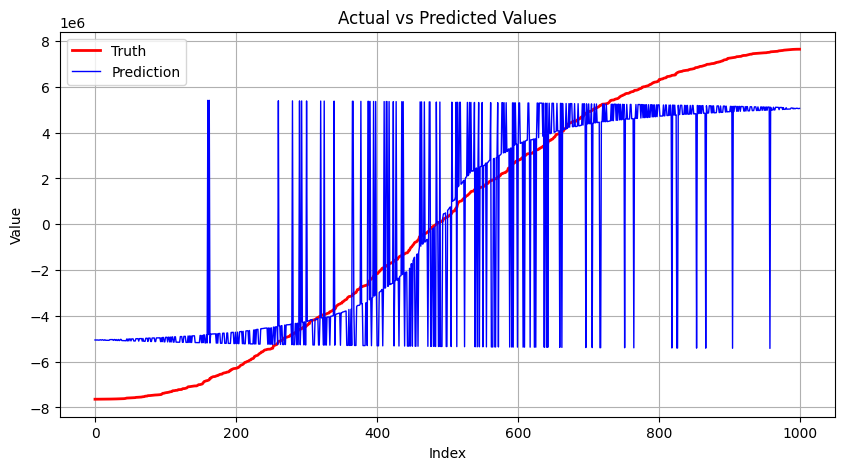

In [9]:
run_sym_reg_gp(2)

### Problem 3



Problem 3



Generations:  20%|██        | 200/1000 [00:49<03:24,  3.91it/s]

Generation 200:
    Island 1; Best fitness: 316.577630
    Island 2; Best fitness: 97.553798
    Island 3; Best fitness: 839.275169
    Island 4; Best fitness: 227.233233
    Island 5; Best fitness: 312.673854
    Best global fitness: 97.553798
    Best global formula: np.add(np.multiply(4.060442862044449, np.multiply(np.minimum(np.negative(x[1]), x[1]), x[1])), np.subtract(np.subtract(np.cosh(x[0]), np.add(np.sinh(-2.015182463773842), x[2])), np.add(np.add(x[2], -1.8058013521069967), np.add(np.cos(x[0]), np.divide(x[2], 0.6202370655734244)))))



Generations:  40%|████      | 400/1000 [01:38<02:28,  4.04it/s]

Generation 400:
    Island 1; Best fitness: 97.553798
    Island 2; Best fitness: 94.737377
    Island 3; Best fitness: 33.026732
    Island 4; Best fitness: 96.560133
    Island 5; Best fitness: 97.553798
    Best global fitness: 33.026732
    Best global formula: np.add(np.multiply(np.absolute(x[1]), np.multiply(np.minimum(np.negative(x[1]), x[1]), x[1])), np.subtract(np.subtract(np.cosh(x[0]), np.add(np.sinh(-2.015182463773842), x[2])), np.add(np.add(x[2], -1.9699415189846148), np.add(np.cos(x[0]), np.divide(x[2], 0.6202370655734244)))))



Generations:  60%|██████    | 600/1000 [02:28<01:41,  3.93it/s]

Generation 600:
    Island 1; Best fitness: 32.922012
    Island 2; Best fitness: 94.119655
    Island 3; Best fitness: 33.021564
    Island 4; Best fitness: 33.021564
    Island 5; Best fitness: 33.021564
    Best global fitness: 32.922012
    Best global formula: np.add(np.multiply(np.absolute(np.maximum(x[1], -4.964622063445439)), np.multiply(np.minimum(np.negative(x[1]), np.maximum(x[1], -4.964622063445439)), x[1])), np.subtract(np.subtract(np.cosh(x[0]), np.add(np.sinh(-2.015182463773842), x[2])), np.add(np.add(x[2], -1.9699415189846148), np.add(np.cos(x[0]), np.divide(x[2], 0.6608317890232218)))))



Generations:  80%|████████  | 800/1000 [03:19<00:53,  3.72it/s]

Generation 800:
    Island 1; Best fitness: 32.293766
    Island 2; Best fitness: 32.293766
    Island 3; Best fitness: 32.277434
    Island 4; Best fitness: 32.293766
    Island 5; Best fitness: 32.293766
    Best global fitness: 32.277434
    Best global formula: np.add(np.multiply(np.absolute(np.maximum(x[1], -4.964622063445439)), np.multiply(np.minimum(np.negative(x[1]), x[1]), np.maximum(x[1], -4.964622063445439))), np.subtract(np.subtract(np.cosh(x[0]), np.add(np.sinh(-2.1042829646321994), x[2])), np.add(np.add(x[2], -1.9699415189846148), np.add(np.remainder(4.258296237955908, x[0]), np.divide(x[2], 0.6608317890232218)))))



Generations: 100%|██████████| 1000/1000 [04:12<00:00,  3.95it/s]

Generation 1000:
    Island 1; Best fitness: 24.366522
    Island 2; Best fitness: 32.247475
    Island 3; Best fitness: 32.189365
    Island 4; Best fitness: 32.189365
    Island 5; Best fitness: 24.366522
    Best global fitness: 24.366522
    Best global formula: np.add(np.multiply(np.absolute(np.maximum(x[1], -4.973875097263662)), np.multiply(np.minimum(np.negative(x[1]), x[1]), np.maximum(x[1], -4.973875097263662))), np.subtract(np.subtract(np.cosh(np.minimum(4.365965511080824, x[0])), np.add(np.sinh(-2.0174843148004316), x[2])), np.add(np.add(x[2], -1.9699415189846148), np.add(np.remainder(x[0], -2.07102849364453), np.divide(x[2], 0.6608317890232218)))))

Best global formula:  np.add(np.multiply(np.absolute(np.maximum(x[1], -4.973875097263662)), np.multiply(np.minimum(np.negative(x[1]), x[1]), np.maximum(x[1], -4.973875097263662))), np.subtract(np.subtract(np.cosh(np.minimum(4.365965511080824, x[0])), np.add(np.sinh(-2.0174843148004316), x[2])), np.add(np.add(x[2], -1.96994151898

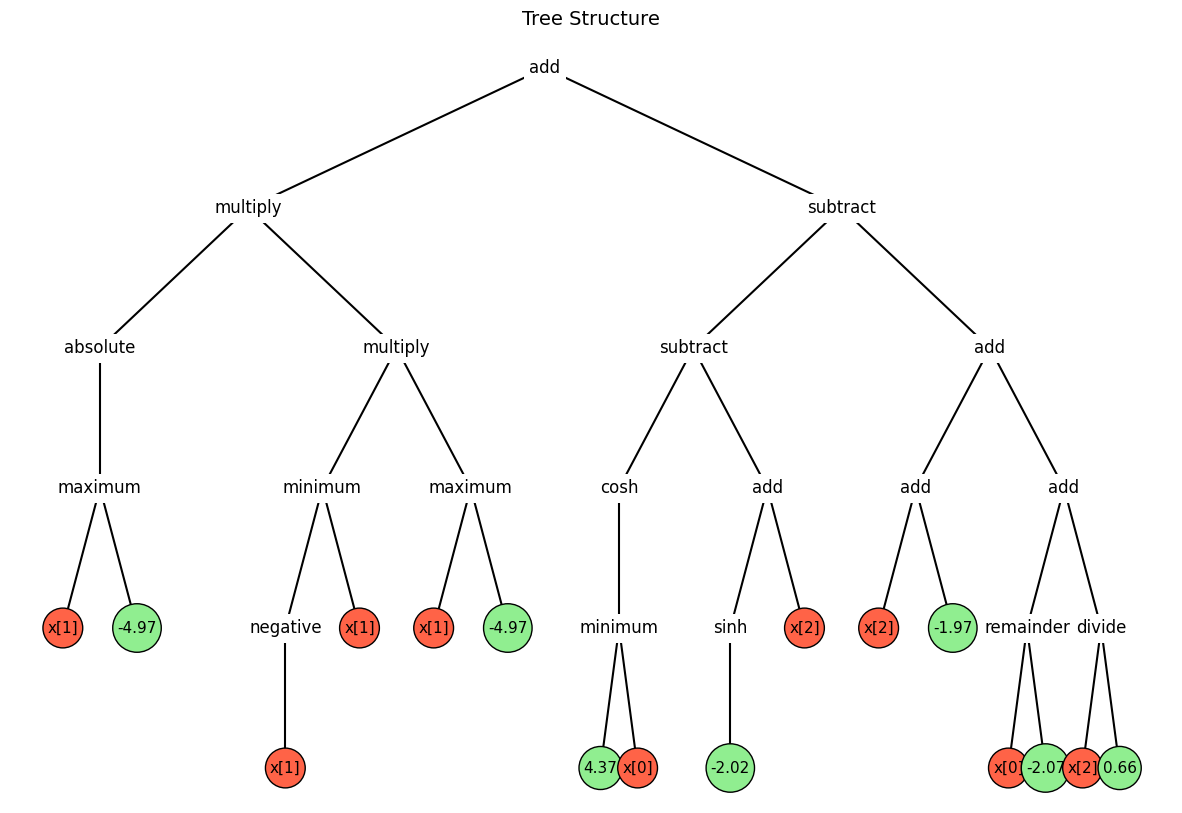

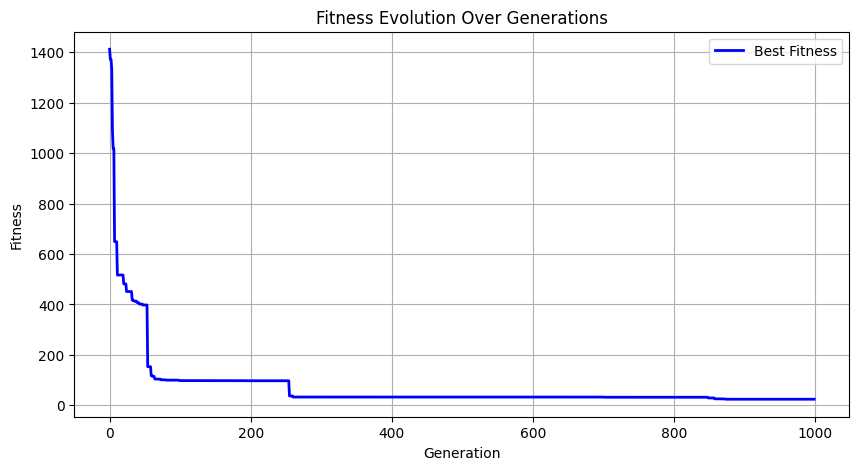

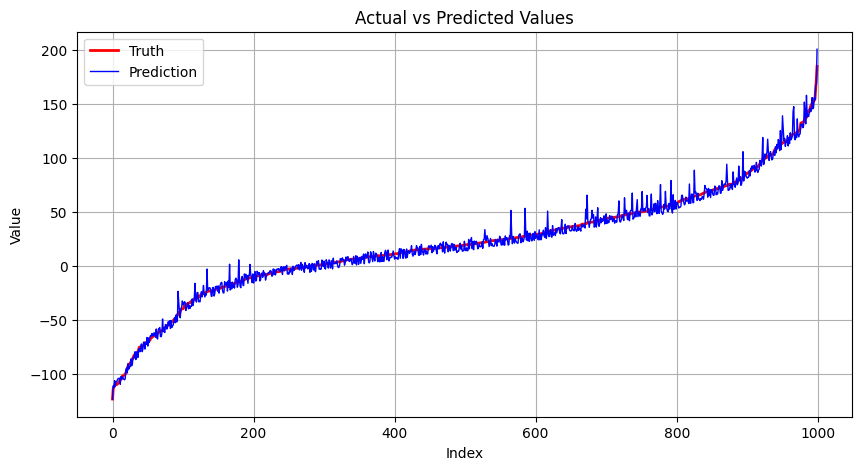

In [10]:
run_sym_reg_gp(3)

### Problem 4



Problem 4



Generations:  20%|██        | 200/1000 [00:40<02:41,  4.94it/s]

Generation 200:
    Island 1; Best fitness: 1.576716
    Island 2; Best fitness: 0.166404
    Island 3; Best fitness: 8.394405
    Island 4; Best fitness: 8.002929
    Island 5; Best fitness: 19.095450
    Best global fitness: 0.166404
    Best global formula: np.subtract(2.6304202727097303, np.minimum(np.multiply(np.add(-2.5649473664638034, -5.273946369898773), np.cos(x[1])), np.multiply(np.add(-0.7516281549583637, -5.346900850453079), np.cos(x[1]))))



Generations:  40%|████      | 400/1000 [01:27<02:22,  4.21it/s]

Generation 400:
    Island 1; Best fitness: 0.151004
    Island 2; Best fitness: 0.101489
    Island 3; Best fitness: 0.100770
    Island 4; Best fitness: 0.117227
    Island 5; Best fitness: 0.116444
    Best global fitness: 0.100770
    Best global formula: np.subtract(2.8317809501274676, np.minimum(np.multiply(np.add(-2.5649473664638034, -5.062245130716221), np.cos(x[1])), np.multiply(np.cos(x[1]), np.add(np.cos(x[1]), np.add(-5.648104136297606, 0.041896408583709466)))))



Generations:  60%|██████    | 600/1000 [02:13<01:29,  4.48it/s]

Generation 600:
    Island 1; Best fitness: 0.096306
    Island 2; Best fitness: 0.100398
    Island 3; Best fitness: 0.090528
    Island 4; Best fitness: 0.096046
    Island 5; Best fitness: 0.095867
    Best global fitness: 0.090528
    Best global formula: np.subtract(2.920784496970211, np.minimum(np.multiply(np.add(-2.5649473664638034, -4.809520979827862), np.cos(x[1])), np.multiply(np.cos(x[1]), np.add(np.cos(x[1]), np.minimum(-5.648104136297606, 0.041896408583709466)))))



Generations:  80%|████████  | 800/1000 [03:00<00:47,  4.23it/s]

Generation 800:
    Island 1; Best fitness: 0.075258
    Island 2; Best fitness: 0.091609
    Island 3; Best fitness: 0.088652
    Island 4; Best fitness: 0.075395
    Island 5; Best fitness: 0.075215
    Best global fitness: 0.075215
    Best global formula: np.subtract(3.1183604409253194, np.minimum(np.multiply(np.add(np.subtract(2.7575359295360498, 4.594352143311782), -5.346900850453079), np.cos(np.add(-0.010017360938570086, x[1]))), np.multiply(np.add(-1.479426387566738, -5.346900850453079), np.cos(x[1]))))



Generations: 100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]

Generation 1000:
    Island 1; Best fitness: 0.055235
    Island 2; Best fitness: 0.075258
    Island 3; Best fitness: 0.055235
    Island 4; Best fitness: 0.055235
    Island 5; Best fitness: 0.055235
    Best global fitness: 0.055235
    Best global formula: np.subtract(np.maximum(np.arccos(np.tanh(np.multiply(5.5921039198210485, x[0]))), np.arccos(np.tanh(np.divide(-4.350344424685952, x[0])))), np.minimum(np.multiply(np.add(-2.5649473664638034, np.minimum(-4.786393096058477, x[0])), np.cos(x[1])), np.multiply(np.cos(x[1]), np.add(np.cos(x[1]), np.subtract(-5.648104136297606, 0.041896408583709466)))))

Best global formula:  np.subtract(np.maximum(np.arccos(np.tanh(np.multiply(5.5921039198210485, x[0]))), np.arccos(np.tanh(np.divide(-4.350344424685952, x[0])))), np.minimum(np.multiply(np.add(-2.5649473664638034, np.minimum(-4.786393096058477, x[0])), np.cos(x[1])), np.multiply(np.cos(x[1]), np.add(np.cos(x[1]), np.subtract(-5.648104136297606, 0.041896408583709466)))))
Best training fi

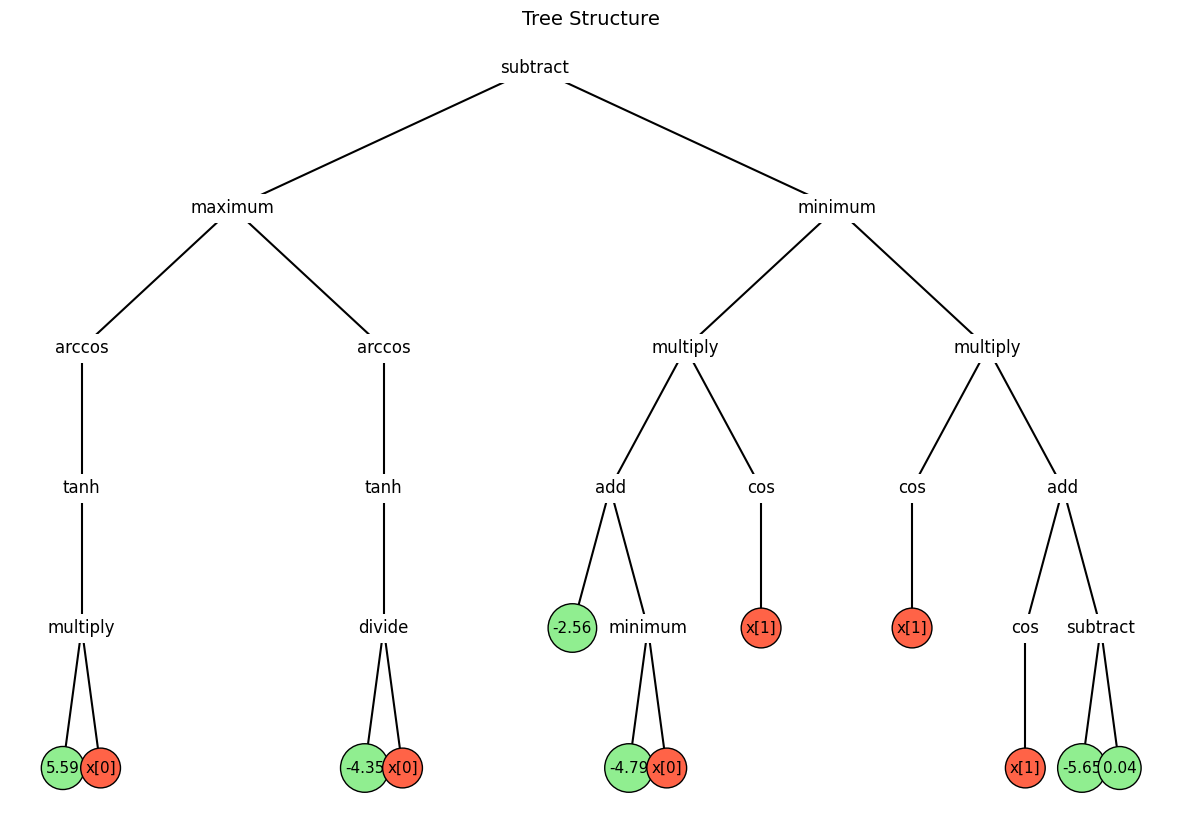

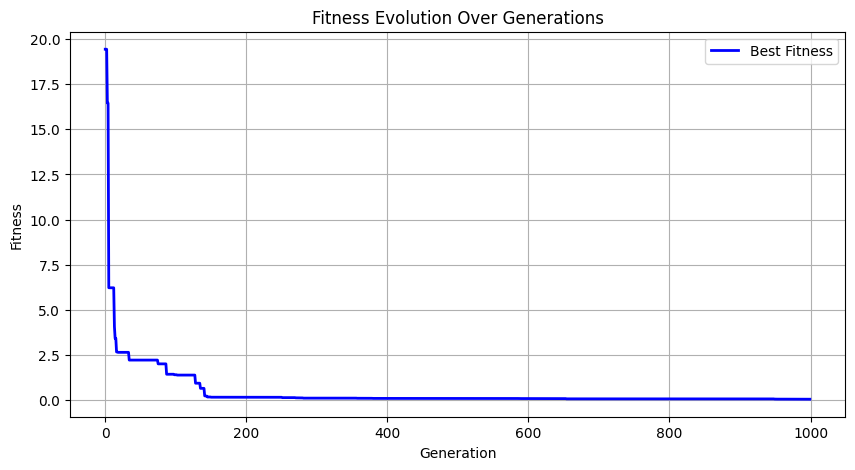

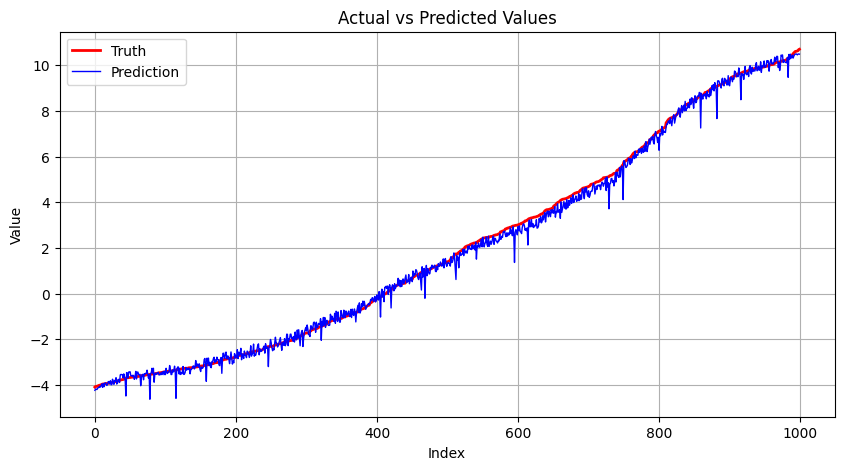

In [11]:
run_sym_reg_gp(4)

### Problem 5



Problem 5



Generations:  20%|██        | 201/1000 [00:40<02:17,  5.81it/s]

Generation 200:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(np.square(np.cosh(np.maximum(np.add(x[1], x[0]), x[1]))), -3.3869253024687094e-16)



Generations:  40%|████      | 401/1000 [01:12<01:35,  6.28it/s]

Generation 400:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(np.square(-2.180789186394816e-05), np.minimum(np.multiply(np.add(np.subtract(x[0], x[1]), x[0]), np.divide(np.subtract(3.495395070093316, x[1]), np.reciprocal(x[0]))), np.square(-2.180789186394816e-05)))



Generations:  60%|██████    | 601/1000 [01:43<00:59,  6.75it/s]

Generation 600:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(np.square(-2.180789186394816e-05), np.minimum(np.multiply(np.add(np.subtract(x[0], x[1]), np.minimum(x[0], x[1])), np.divide(np.subtract(3.495395070093316, x[1]), np.reciprocal(x[0]))), np.square(np.divide(np.arcsin(0.4813792270492262), np.maximum(x[1], 1.1443233734375182)))))



Generations:  80%|████████  | 801/1000 [02:14<00:32,  6.16it/s]

Generation 800:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(np.square(-2.180789186394816e-05), np.minimum(np.multiply(np.add(np.subtract(x[0], x[1]), np.maximum(2.003594136995283, x[0])), np.divide(np.subtract(3.495395070093316, x[1]), np.reciprocal(x[0]))), np.absolute(np.divide(np.arctan(-0.19151399974052877), x[0]))))



Generations: 100%|██████████| 1000/1000 [02:48<00:00,  5.93it/s]


Generation 1000:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.multiply(np.minimum(np.multiply(np.add(np.subtract(x[0], x[1]), np.maximum(2.2612182619474845, x[0])), np.divide(np.subtract(3.495395070093316, x[1]), np.reciprocal(x[0]))), np.arctan(np.divide(np.reciprocal(3.9475633927744758), np.power(x[1], x[1])))), np.square(-2.180789186394816e-05))

Best global formula:  np.multiply(np.minimum(np.multiply(np.add(np.subtract(x[0], x[1]), np.maximum(2.2612182619474845, x[0])), np.divide(np.subtract(3.495395070093316, x[1]), np.reciprocal(x[0]))), np.arctan(np.divide(np.reciprocal(3.9475633927744758), np.power(x[1], x[1])))), np.square(-2.180789186394816e-05))
Best training fitness:  3.8474618146882014e-19
Best testing fitness:  3.7523280241624113e-19


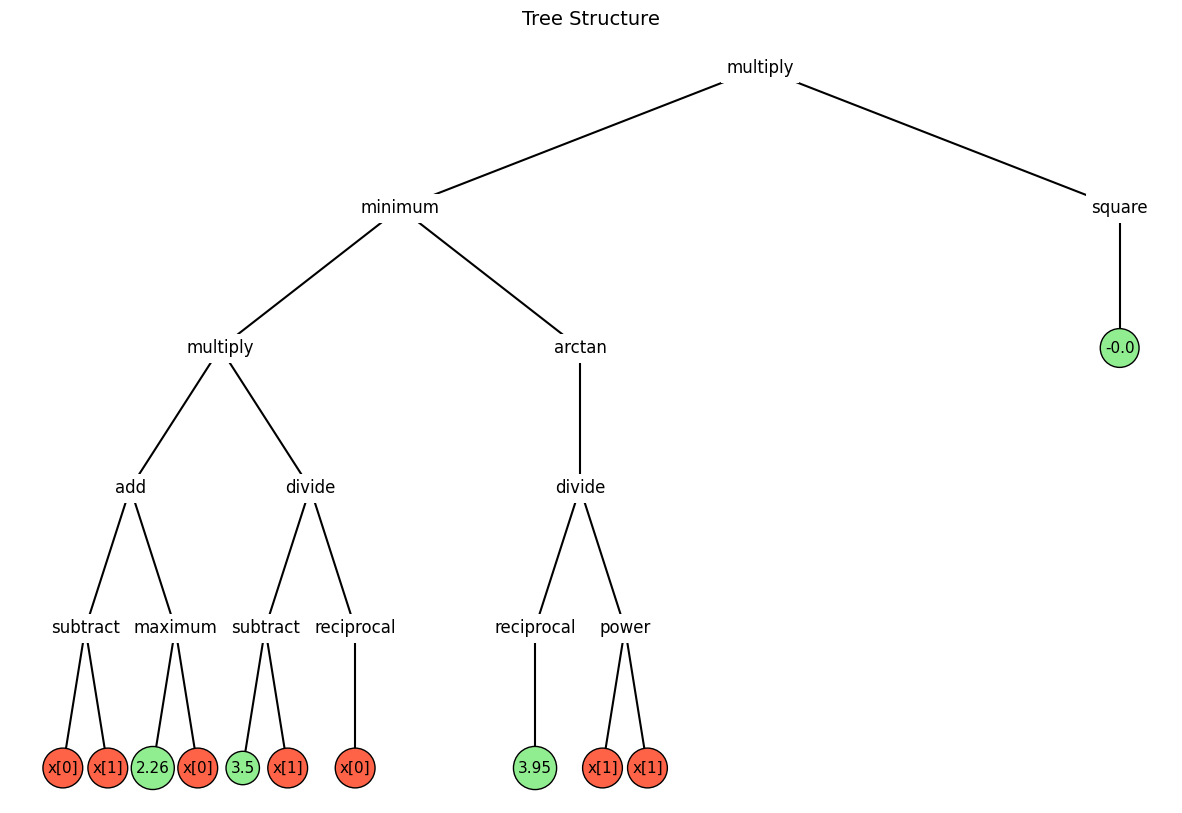

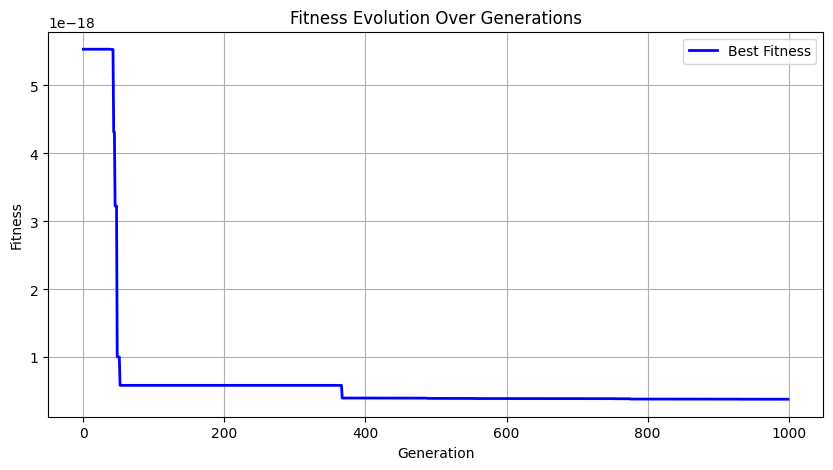

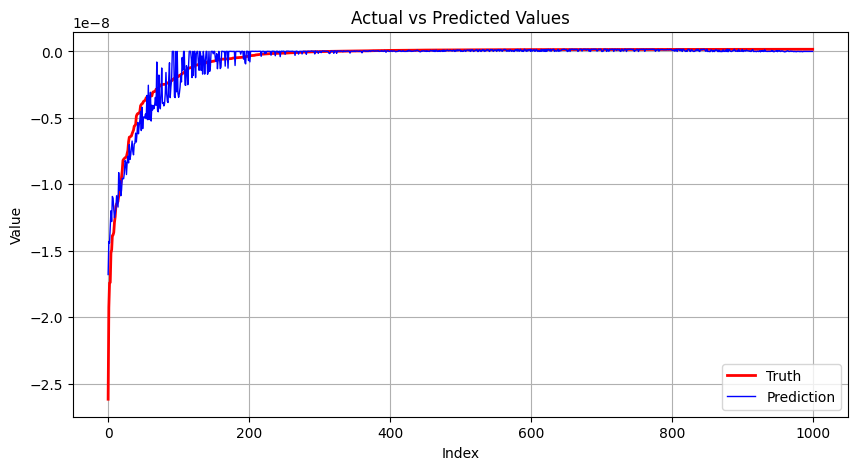

In [12]:
run_sym_reg_gp(5)

### Problem 6



Problem 6



Generations:  20%|██        | 201/1000 [00:37<02:38,  5.04it/s]

Generation 200:
    Island 1; Best fitness: 0.121072
    Island 2; Best fitness: 0.204831
    Island 3; Best fitness: 0.001301
    Island 4; Best fitness: 0.308174
    Island 5; Best fitness: 0.401460
    Best global fitness: 0.001301
    Best global formula: np.add(np.add(np.multiply(np.add(x[1], np.remainder(-4.449153943623032, 4.555540068766143)), np.maximum(-0.0974477804335967, -4.8350566121696135)), np.add(np.multiply(x[1], np.maximum(-0.0974477804335967, -4.8350566121696135)), x[1])), np.add(np.multiply(x[0], np.add(np.maximum(-0.7971972842251871, -2.217390572617132), np.sin(0.11020652381806872))), np.add(np.multiply(x[1], -0.0974477804335967), x[1])))



Generations:  40%|████      | 401/1000 [01:15<01:50,  5.44it/s]

Generation 400:
    Island 1; Best fitness: 0.000316
    Island 2; Best fitness: 0.017947
    Island 3; Best fitness: 0.000268
    Island 4; Best fitness: 0.000281
    Island 5; Best fitness: 0.000269
    Best global fitness: 0.000268
    Best global formula: np.add(np.add(np.multiply(np.add(x[1], np.log(1.1820789336451591)), np.maximum(-0.0974477804335967, -0.0974477804335967)), np.add(np.multiply(x[1], np.maximum(-0.0974477804335967, -4.8350566121696135)), x[1])), np.add(np.multiply(x[0], np.add(np.maximum(-0.7971972842251871, -4.79648789365918), np.tanh(0.11020652381806872))), np.add(np.multiply(np.multiply(1.1761942159177892, x[1]), -0.0974477804335967), x[1])))



Generations:  60%|██████    | 601/1000 [01:53<01:16,  5.24it/s]

Generation 600:
    Island 1; Best fitness: 0.000186
    Island 2; Best fitness: 0.000316
    Island 3; Best fitness: 0.000268
    Island 4; Best fitness: 0.000209
    Island 5; Best fitness: 0.000190
    Best global fitness: 0.000186
    Best global formula: np.add(np.add(np.multiply(np.add(x[1], np.log(1.1820789336451591)), np.maximum(-0.0974477804335967, -0.0974477804335967)), np.add(np.multiply(x[1], np.maximum(-0.0974477804335967, -4.8350566121696135)), x[1])), np.add(np.multiply(x[0], np.add(np.maximum(-0.7971972842251871, -4.79648789365918), np.sin(3.0327581081551704))), np.add(np.multiply(np.multiply(1.1654391145635774, x[1]), -0.0974477804335967), x[1])))



Generations:  80%|████████  | 801/1000 [02:31<00:39,  5.10it/s]

Generation 800:
    Island 1; Best fitness: 0.000143
    Island 2; Best fitness: 0.000186
    Island 3; Best fitness: 0.000186
    Island 4; Best fitness: 0.000186
    Island 5; Best fitness: 0.000143
    Best global fitness: 0.000143
    Best global formula: np.add(np.add(np.multiply(np.add(x[1], np.log(1.1135794785464643)), np.maximum(-0.0974477804335967, -4.8350566121696135)), np.reciprocal(np.divide(np.exp(0.09836178124853223), np.minimum(x[1], 3.1764013732538716)))), np.add(np.multiply(x[0], np.add(np.maximum(-0.7971972842251871, -4.79648789365918), np.sin(3.0327581081551704))), np.add(np.multiply(np.multiply(1.1761942159177892, x[1]), -0.0974477804335967), x[1])))



Generations: 100%|██████████| 1000/1000 [03:11<00:00,  5.22it/s]

Generation 1000:
    Island 1; Best fitness: 0.000143
    Island 2; Best fitness: 0.000143
    Island 3; Best fitness: 0.000143
    Island 4; Best fitness: 0.000143
    Island 5; Best fitness: 0.000143
    Best global fitness: 0.000143
    Best global formula: np.add(np.add(np.multiply(np.add(x[1], np.log(1.1135794785464643)), np.maximum(-0.0974477804335967, -4.8350566121696135)), np.reciprocal(np.divide(np.exp(0.09836178124853223), np.minimum(x[1], 3.1764013732538716)))), np.add(np.multiply(x[0], np.add(np.maximum(-0.7971972842251871, -4.79648789365918), np.sin(3.0327581081551704))), np.add(np.multiply(np.multiply(1.1761942159177892, x[1]), -0.0974477804335967), x[1])))

Best global formula:  np.add(np.add(np.multiply(np.add(x[1], np.log(1.1135794785464643)), np.maximum(-0.0974477804335967, -4.8350566121696135)), np.reciprocal(np.divide(np.exp(0.09836178124853223), np.minimum(x[1], 3.1764013732538716)))), np.add(np.multiply(x[0], np.add(np.maximum(-0.7971972842251871, -4.7964878936591

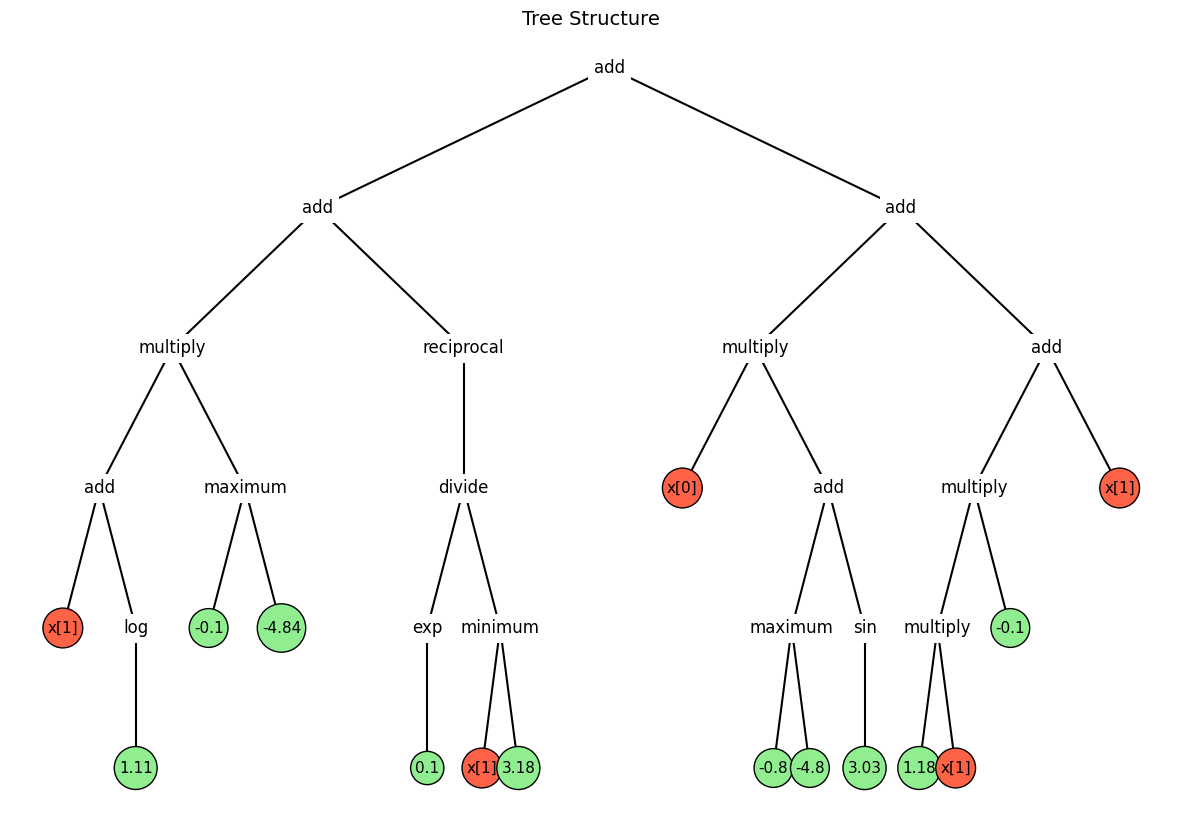

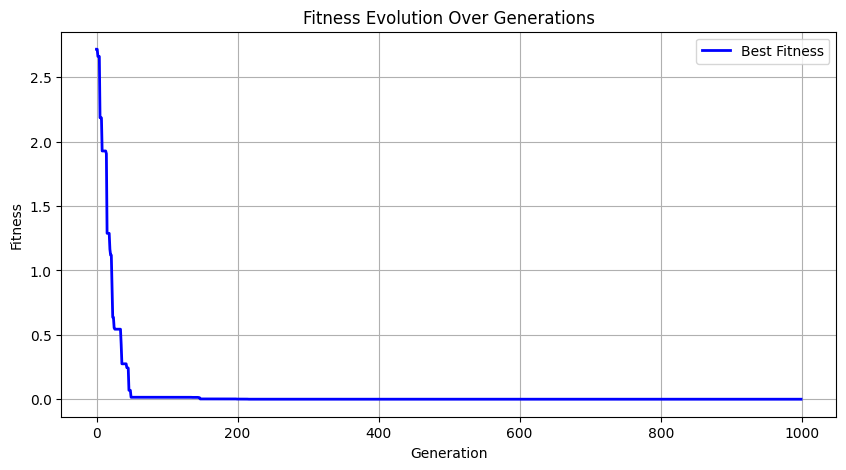

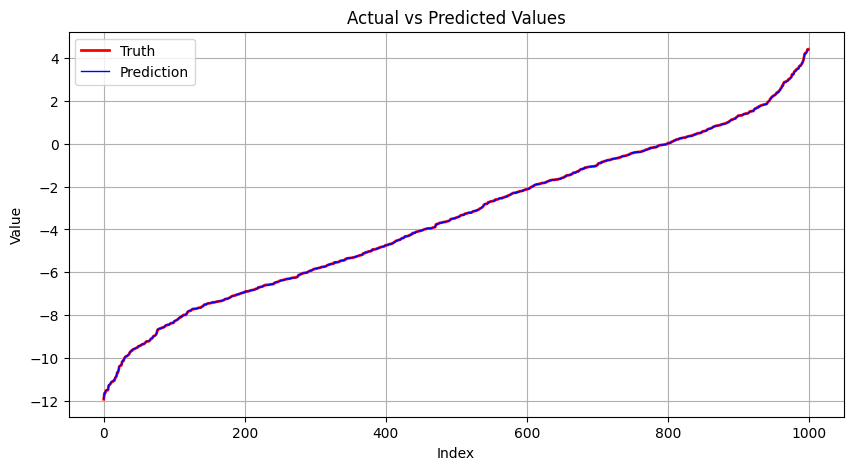

In [13]:
run_sym_reg_gp(6)

### Problem 7



Problem 7



Generations:  20%|██        | 201/1000 [00:42<02:40,  4.98it/s]

Generation 200:
    Island 1; Best fitness: 341.278247
    Island 2; Best fitness: 328.782805
    Island 3; Best fitness: 356.609368
    Island 4; Best fitness: 349.551552
    Island 5; Best fitness: 379.360508
    Best global fitness: 328.782805
    Best global formula: np.cosh(np.subtract(-2.2359849169251325, np.multiply(np.maximum(x[0], np.minimum(-0.8984784469348774, x[1])), x[1])))



Generations:  40%|████      | 400/1000 [01:18<01:54,  5.25it/s]

Generation 400:
    Island 1; Best fitness: 327.472723
    Island 2; Best fitness: 327.540553
    Island 3; Best fitness: 315.427092
    Island 4; Best fitness: 326.528015
    Island 5; Best fitness: 323.017224
    Best global fitness: 315.427092
    Best global formula: np.cosh(np.subtract(-2.262503325896825, np.multiply(np.maximum(x[0], np.minimum(-0.8065231830001711, x[1])), np.maximum(x[1], np.minimum(x[0], -0.837836760452181)))))



Generations:  60%|██████    | 601/1000 [01:52<01:02,  6.35it/s]

Generation 600:
    Island 1; Best fitness: 313.502919
    Island 2; Best fitness: 323.731467
    Island 3; Best fitness: 315.425896
    Island 4; Best fitness: 315.425896
    Island 5; Best fitness: 314.352491
    Best global fitness: 313.502919
    Best global formula: np.sinh(np.subtract(np.multiply(np.maximum(x[0], np.minimum(-0.8065231830001711, x[1])), np.maximum(x[1], np.minimum(x[0], -0.8106094718463404))), -2.280284342585475))



Generations:  80%|████████  | 801/1000 [02:23<00:29,  6.85it/s]

Generation 800:
    Island 1; Best fitness: 313.501384
    Island 2; Best fitness: 313.351454
    Island 3; Best fitness: 313.501615
    Island 4; Best fitness: 313.501615
    Island 5; Best fitness: 310.156785
    Best global fitness: 310.156785
    Best global formula: np.cosh(np.subtract(-2.280284342585475, np.multiply(np.maximum(np.add(-0.057944459299530404, x[0]), np.minimum(-1.2412509359118018, x[1])), np.maximum(x[1], np.minimum(x[0], -0.7943629566868662)))))



Generations: 100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]


Generation 1000:
    Island 1; Best fitness: 310.069958
    Island 2; Best fitness: 311.513922
    Island 3; Best fitness: 311.513922
    Island 4; Best fitness: 311.513922
    Island 5; Best fitness: 310.069958
    Best global fitness: 310.069958
    Best global formula: np.cosh(np.subtract(-2.280284342585475, np.multiply(np.maximum(np.add(-0.0416842700855411, x[0]), np.minimum(-1.2412509359118018, x[1])), np.maximum(x[1], np.minimum(x[0], -0.716333093981695)))))

Best global formula:  np.cosh(np.subtract(-2.280284342585475, np.multiply(np.maximum(np.add(-0.0416842700855411, x[0]), np.minimum(-1.2412509359118018, x[1])), np.maximum(x[1], np.minimum(x[0], -0.716333093981695)))))
Best training fitness:  310.0699579606381
Best testing fitness:  254.6867317552637


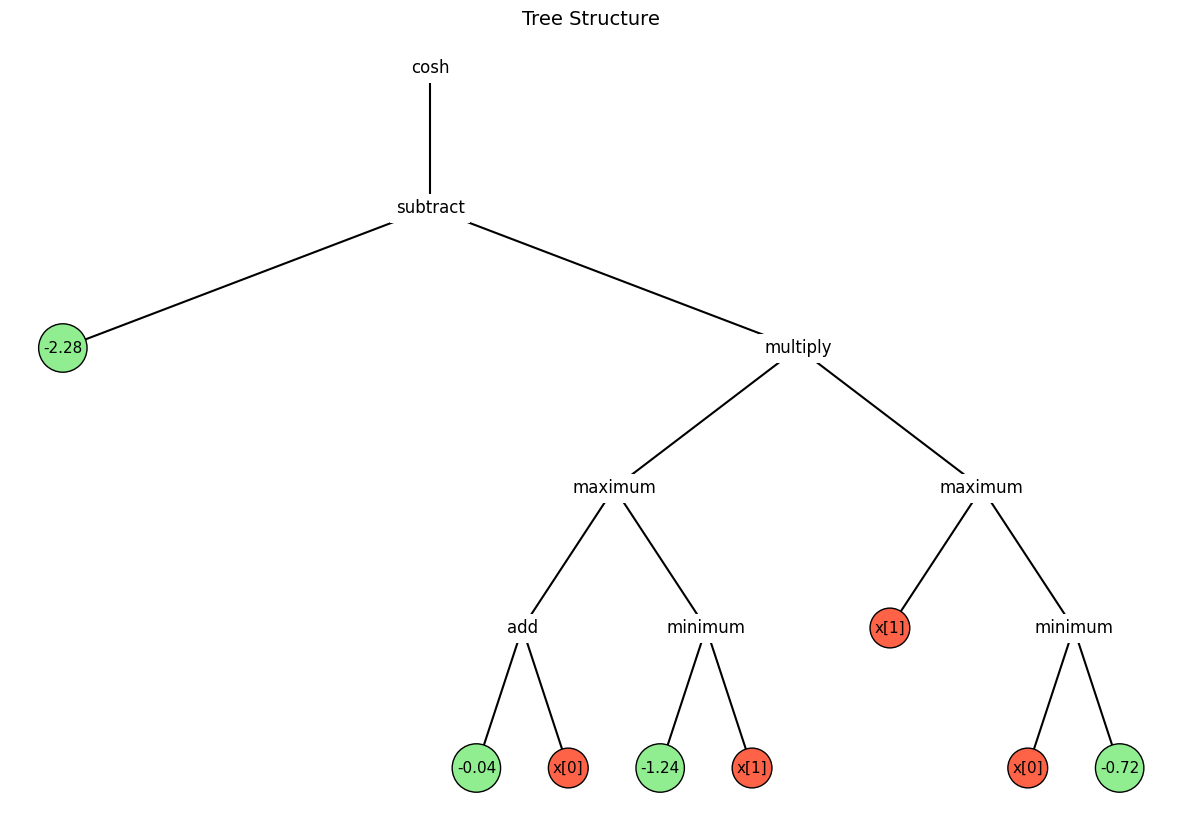

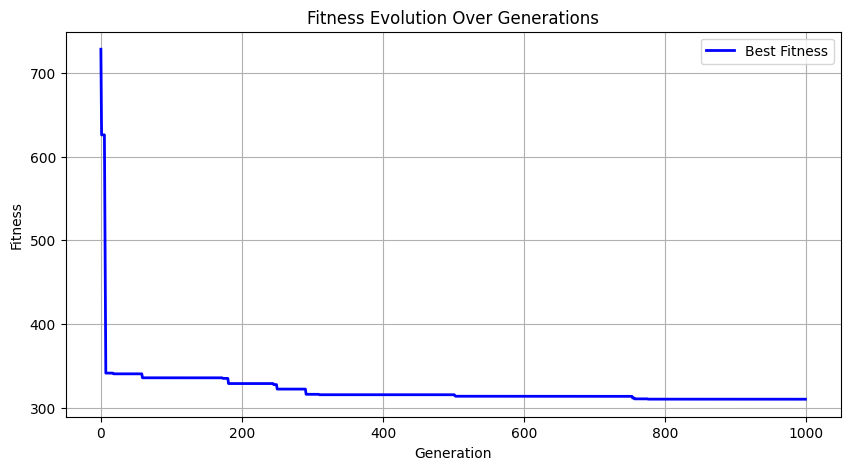

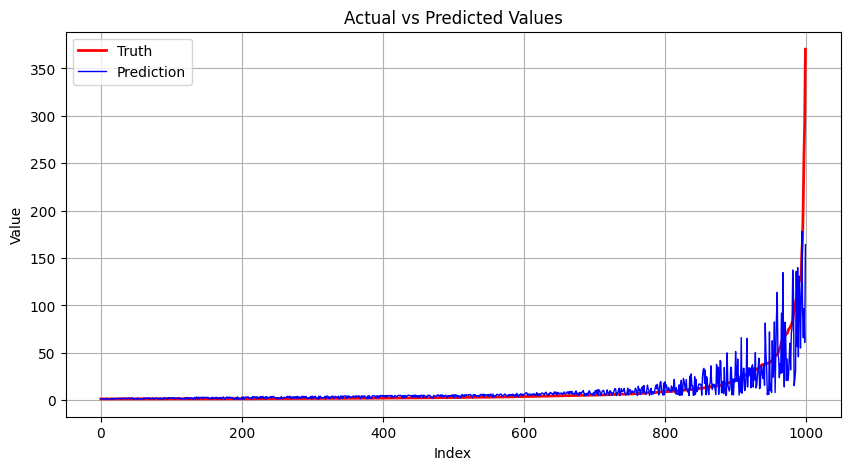

In [14]:
run_sym_reg_gp(7)

### Problem 8



Problem 8



Generations:  20%|██        | 200/1000 [05:30<19:48,  1.49s/it]

Generation 200:
    Island 1; Best fitness: 5634921.420542
    Island 2; Best fitness: 786469.618109
    Island 3; Best fitness: 2132095.558014
    Island 4; Best fitness: 666691.121822
    Island 5; Best fitness: 1288259.638796
    Best global fitness: 666691.121822
    Best global formula: np.multiply(np.subtract(np.add(114.57246359623406, np.exp(x[5])), np.subtract(np.sinh(x[5]), np.exp(2.5420776044198927))), np.subtract(np.subtract(np.exp(np.minimum(0.6776720542632209, x[3])), np.subtract(np.cos(-4.000236825487477), np.sinh(x[5]))), np.subtract(np.absolute(np.subtract(3.237690461685311, -2.153496690411326)), x[5])))



Generations:  40%|████      | 400/1000 [10:56<15:20,  1.53s/it]

Generation 400:
    Island 1; Best fitness: 472308.644997
    Island 2; Best fitness: 742699.531114
    Island 3; Best fitness: 570373.260140
    Island 4; Best fitness: 451141.963687
    Island 5; Best fitness: 421826.010552
    Best global fitness: 421826.010552
    Best global formula: np.multiply(np.subtract(np.subtract(np.arctan(x[4]), np.subtract(np.maximum(0.5138014260496435, x[4]), np.sinh(x[5]))), np.subtract(np.absolute(x[4]), x[5])), np.subtract(np.add(114.57246359623406, np.exp(x[5])), np.subtract(np.sinh(x[5]), np.exp(2.5420776044198927))))



Generations:  60%|██████    | 600/1000 [17:06<14:13,  2.13s/it]

Generation 600:
    Island 1; Best fitness: 344213.405536
    Island 2; Best fitness: 435150.117288
    Island 3; Best fitness: 449086.949447
    Island 4; Best fitness: 372886.851820
    Island 5; Best fitness: 373575.585008
    Best global fitness: 344213.405536
    Best global formula: np.multiply(np.subtract(np.add(114.57246359623406, np.exp(x[5])), np.subtract(np.sinh(x[5]), np.multiply(-5.42828459880723, np.minimum(x[4], -4.388691341438574)))), np.subtract(np.subtract(np.minimum(np.subtract(x[4], -1.5587014379899893), np.tanh(-0.6666979541350022)), np.subtract(np.cbrt(x[5]), np.sinh(x[5]))), np.subtract(np.absolute(x[4]), x[5])))



Generations:  80%|████████  | 800/1000 [24:25<08:27,  2.54s/it]

Generation 800:
    Island 1; Best fitness: 342765.068696
    Island 2; Best fitness: 342498.593221
    Island 3; Best fitness: 336620.927668
    Island 4; Best fitness: 342515.035490
    Island 5; Best fitness: 340176.375535
    Best global fitness: 336620.927668
    Best global formula: np.multiply(np.subtract(np.add(114.57246359623406, np.exp(x[5])), np.subtract(np.sinh(x[5]), np.multiply(-5.42828459880723, -4.645966581406143))), np.subtract(np.subtract(np.minimum(np.subtract(x[4], -1.5587014379899893), np.tanh(x[3])), np.subtract(np.cbrt(x[5]), np.sinh(x[5]))), np.subtract(np.absolute(x[4]), np.multiply(x[5], 0.9293568845654132))))



Generations: 100%|██████████| 1000/1000 [32:03<00:00,  1.92s/it]

Generation 1000:
    Island 1; Best fitness: 200784.364464
    Island 2; Best fitness: 341990.216814
    Island 3; Best fitness: 200784.364464
    Island 4; Best fitness: 200784.364464
    Island 5; Best fitness: 200784.364464
    Best global fitness: 200784.364464
    Best global formula: np.multiply(np.subtract(np.add(114.57246359623406, np.exp(x[5])), np.subtract(np.sinh(x[5]), np.multiply(-4.708598611033789, -5.42828459880723))), np.subtract(np.subtract(np.minimum(np.subtract(x[4], -3.4939274899130344), np.tanh(x[3])), np.subtract(np.cbrt(x[5]), np.sinh(x[5]))), np.subtract(np.divide(np.square(x[4]), 2.579579025259571), np.multiply(x[5], 0.9293568845654132))))

Best global formula:  np.multiply(np.subtract(np.add(114.57246359623406, np.exp(x[5])), np.subtract(np.sinh(x[5]), np.multiply(-4.708598611033789, -5.42828459880723))), np.subtract(np.subtract(np.minimum(np.subtract(x[4], -3.4939274899130344), np.tanh(x[3])), np.subtract(np.cbrt(x[5]), np.sinh(x[5]))), np.subtract(np.divide(

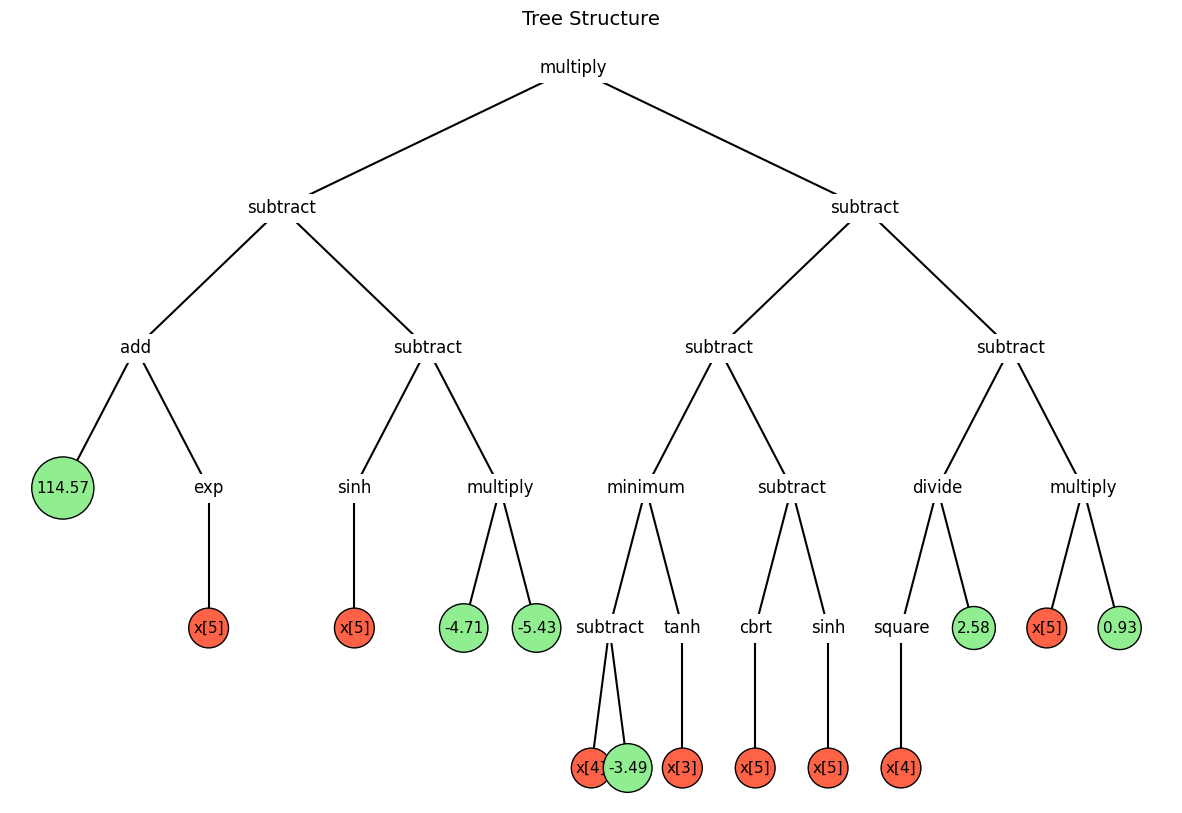

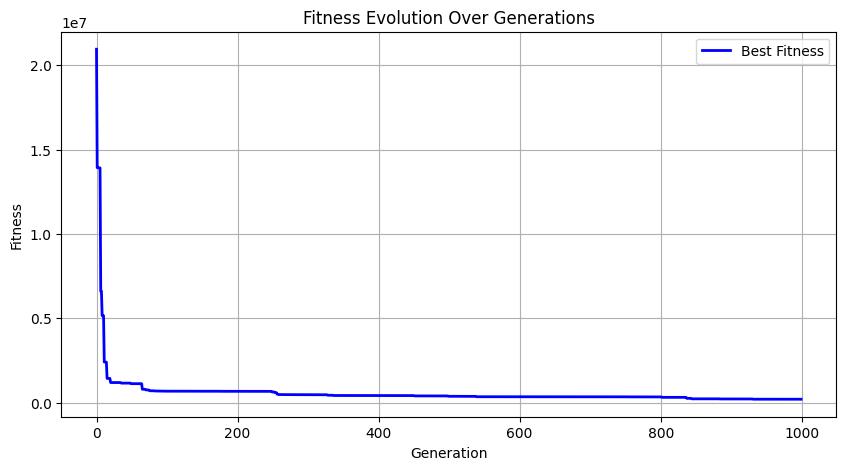

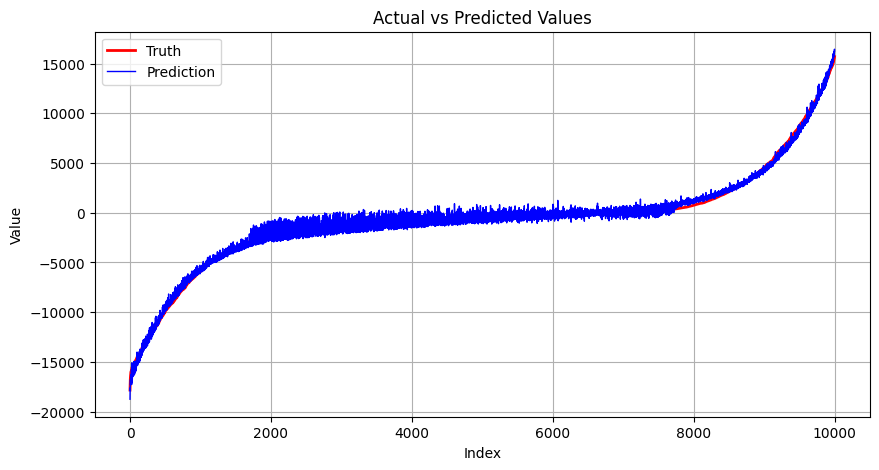

In [15]:
run_sym_reg_gp(8)